In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, auc
)

import joblib

In [93]:
# 1. Загрузка данных
df = pd.read_csv('disney_princess_popularity_dataset_300_rows.csv')
display(df.head())

,PrincessName,FirstMovieTitle,FirstMovieYear,MovieRuntimeMinutes,NumberOfSongs,HasSoloSong,HasDuet,HairColor,EyeColor,OutfitPrimaryColor,...,RottenTomatoesScore,BoxOfficeMillions,AvgScreenTimeMinutes,NumMerchItemsOnAmazon,GoogleSearchIndex2024,InstagramFanPages,TikTokHashtagViewsMillions,Top3Hashtags,IsIconic,PopularityScore
0,Pocahontas,Pocahontas's Adventure,1977,85,4,No,Yes,Brown,Green,Pink,...,88,661,25,2524,68,298,481,#TeamPocahontas #LovePocahontas #PocahontasFor...,Yes,88
1,Mulan,Mulan's Adventure,1995,85,1,Yes,Yes,Blonde,Brown,Purple,...,91,688,52,4202,49,133,619,#TeamMulan #LoveMulan #MulanForever,Yes,78
2,Raya,Raya's Adventure,1989,110,4,No,No,Blonde,Hazel,Pink,...,76,790,54,525,68,129,230,#TeamRaya #LoveRaya #RayaForever,No,53
3,Anna,Anna's Adventure,1940,78,1,No,No,Brown,Grey,Green,...,70,820,42,1951,73,138,697,#TeamAnna #LoveAnna #AnnaForever,Yes,84
4,Mulan,Mulan's Adventure,1943,103,7,No,Yes,White,Brown,Green,...,86,996,55,3958,34,155,200,#TeamMulan #LoveMulan #MulanForever,Yes,71



Информация о типах данных:
PrincessName                   object
FirstMovieTitle                object
FirstMovieYear                  int64
MovieRuntimeMinutes             int64
NumberOfSongs                   int64
HasSoloSong                    object
HasDuet                        object
HairColor                      object
EyeColor                       object
OutfitPrimaryColor             object
OutfitStyleEra                 object
IsRoyalByBirth                 object
HasAnimalSidekick              object
SidekickType                   object
HasMagicalPowers               object
MagicType                      object
MainSetting                    object
IsBasedOnRealStory             object
CulturalOrigin                 object
SpeaksToAnimals                object
FightsVillainDirectly          object
RomanticSubplot                object
MarriedByEnd                   object
VillainName                    object
VillainType                    object
IMDB_Rating           

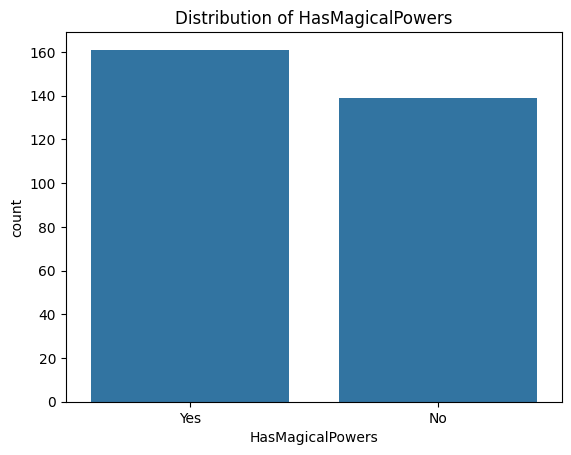

In [94]:
# 2. Первичный анализ данных
print("\nИнформация о типах данных:")
print(df.dtypes)

print("\nПропущенные значения:")
print(df.isna().sum())

print("\nОписание числовых признаков:")
print(df.describe())

# Распределение целевой переменной
sns.countplot(x='HasMagicalPowers', data=df)
plt.title('Distribution of HasMagicalPowers')
plt.show()

In [95]:
# 3. Выбор признаков и целевой переменной
X = df.drop([
    'HasMagicalPowers','SidekickType', 'PrincessName', 'FirstMovieTitle', 'FirstMovieYear',
    'MovieRuntimeMinutes', 'NumberOfSongs', 'HasSoloSong', 'HasDuet',
    'MagicType', 'CulturalOrigin', 'IsBasedOnRealStory', 'FightsVillainDirectly',
    'RomanticSubplot', 'MarriedByEnd', 'VillainName', 'VillainType',
    'IMDB_Rating','OutfitPrimaryColor', 'RottenTomatoesScore', 'BoxOfficeMillions',
    'AvgScreenTimeMinutes', 'MainSetting', 'NumMerchItemsOnAmazon', 'GoogleSearchIndex2024',
    'InstagramFanPages', 'TikTokHashtagViewsMillions', 'Top3Hashtags',
    'IsIconic', 'PopularityScore'
    ], axis=1)

y = df['HasMagicalPowers']

In [96]:
# Преобразование некоторых признаков в категориальные
categorical_features = ['OutfitStyleEra', 'HairColor', 'EyeColor']
for col in categorical_features:
    if col in X.columns:
        X[col] = X[col].astype(str)  # Приводим к строке, чтобы явно указать на категориальность

In [144]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=42, stratify=y)

In [145]:
# Определение типов признаков
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

In [146]:
# Препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Пайплайн с моделью
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])


In [147]:
# Обучение модели
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [148]:
# Оценка модели
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


ROC-AUC Score: 0.5136
Accuracy: 0.5250

Classification Report:
              precision    recall  f1-score   support

          No       0.48      0.32      0.39       111
         Yes       0.55      0.70      0.61       129

    accuracy                           0.53       240
   macro avg       0.51      0.51      0.50       240
weighted avg       0.52      0.53      0.51       240



In [149]:
# Преобразуем 'Yes'/'No' в 1/0
y_test_binary = y_test.map({'No': 0, 'Yes': 1})
y_proba = model.predict_proba(X_test)[:, 1]  # Вероятности положительного класса

оценка качества классификатора

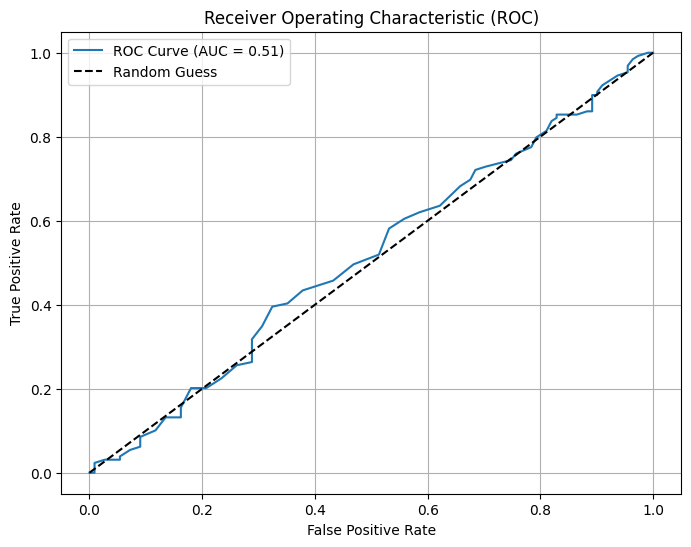

In [150]:
# ROC-кривая
fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
roc_auc = roc_auc_score(y_test_binary, y_proba)

# Визуализация
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid()
plt.show()

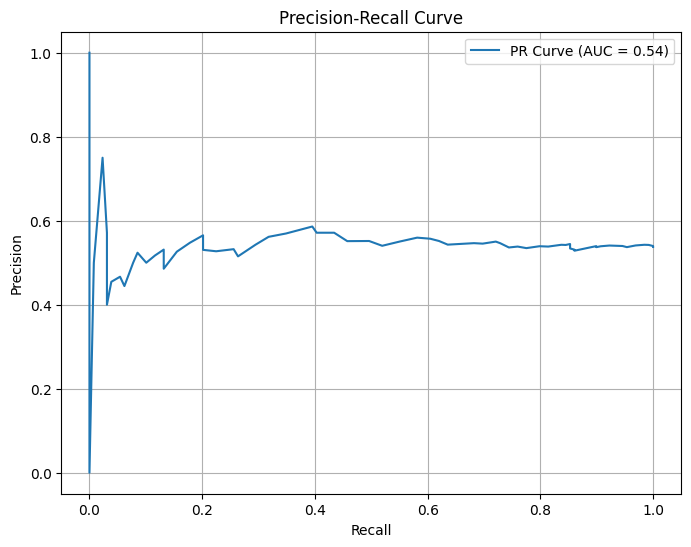

In [151]:
# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test_binary, y_proba)
pr_auc = auc(recall, precision)

# Визуализация PR-кривой
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

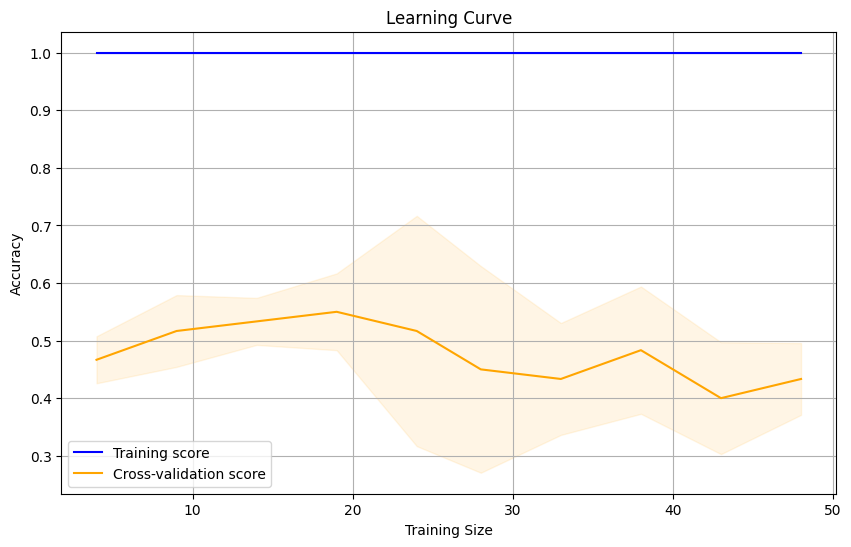

In [126]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Вычисляем среднее и стандартное отклонение
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, label='Cross-validation score', color='orange')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')

plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

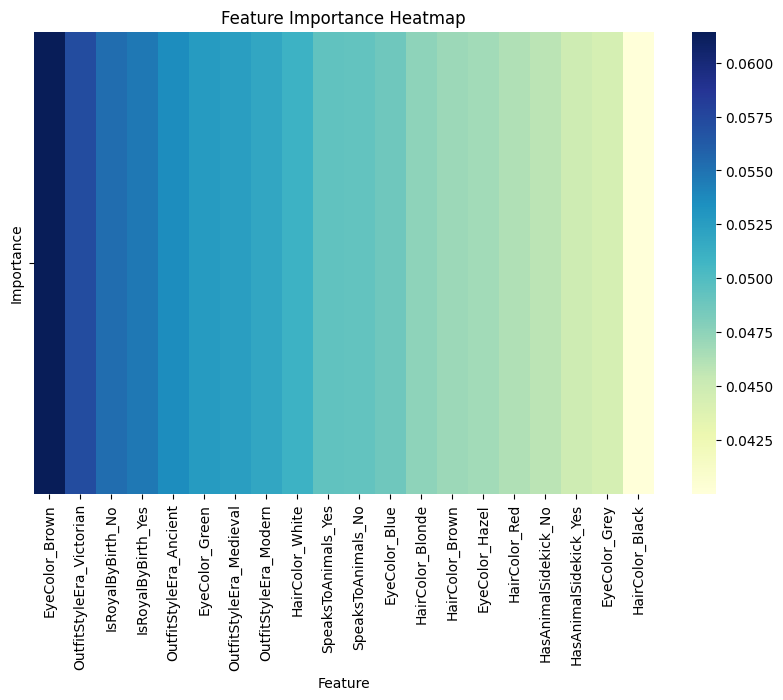

In [86]:
# Feature Importance Heatmap
# Получаем важность признаков
feature_importances = model.named_steps['classifier'].feature_importances_
feature_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features).tolist() + numeric_features

# Создаем DataFrame с важностью признаков
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(importance_df.set_index('Feature').T, cmap='YlGnBu')
plt.title('Feature Importance Heatmap')
plt.show()

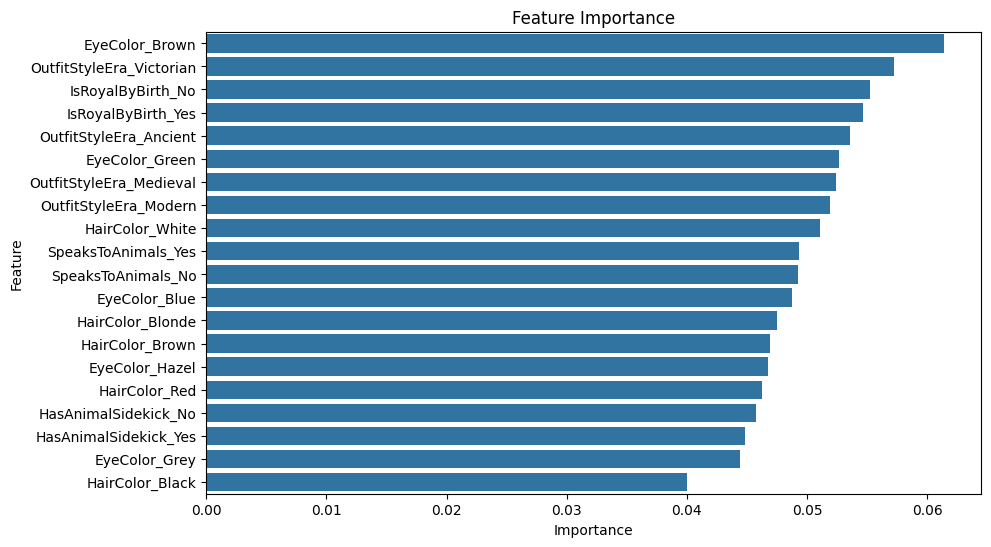

In [87]:
# Feature Importance Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

In [128]:
# Сохранение модели
joblib.dump(model, 'test1.pkl')
print("Модель сохранена")

Модель сохранена
